In [3]:
from sklearn.cluster import KMeans
from sklearn import tree
import pandas as pd
import plotly.express as px
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import graphviz 
from sklearn import preprocessing


In [4]:
df = pd.read_csv('../../data/collisions_routieres.csv')
mapbox_token = "pk.eyJ1IjoidG91amVyMDAiLCJhIjoiY2wwbWt6M3ptMTdhdTNibjU0OGFyMzc3ZiJ9.PYFp4yto8WHEODgZpWbDVQ"
px.set_mapbox_access_token(mapbox_token)
df["DT_ACCDN"] = pd.to_datetime(df["DT_ACCDN"])
df["year"] = df["DT_ACCDN"].dt.year
df["month"] = df["DT_ACCDN"].dt.month
df["day"] = df["DT_ACCDN"].dt.day
df["weekday"] = df["DT_ACCDN"].dt.weekday
df["GRAVE_MORT"] = df["NB_BLESSES_GRAVES"] + df["NB_MORTS"]

df["NB_BLESSE_VEHICULE"] = df['NB_VICTIMES_TOTAL'] \
                        -  df['NB_VICTIMES_PIETON'] \
                        - df['NB_VICTIMES_VELO']

df["NB_BLESSE_VELO_PIETON"] = df['NB_VICTIMES_TOTAL'] -  df['NB_BLESSE_VEHICULE']

df["TYPE_IMPLIQUER"] = df["nb_camionLourd_tractRoutier"].apply(lambda x : "Autre" if x == 0 else "CAMION")


def encodeData(s):
    le = preprocessing.LabelEncoder()
    le = le.fit(pd.unique(s.sort_values().dropna()))
    return le, le.transform(s.values)

# Combien d'accidents, Combien de grave et mortel

In [5]:
df.shape

(204010, 76)

In [122]:
df[df['GRAVITE'].isin(['Grave', 'Mortel'])].shape

(1917, 76)

In [11]:
#Code pour mapbox
# fig = px.scatter_mapbox(df,
#                   lat='LOC_LAT',
#                   lon='LOC_LONG',
#                     height=500)
# fig.update_layout(mapbox_style="dark", mapbox_accesstoken=mapbox_token)
# # fig.write_image('../output/carte_tous_accs.png')

# Tendence depuis Vision Zero Montréal en 2016

In [42]:
graveMortel = df[df['GRAVITE'].isin(['Grave', 'Mortel'])]

In [27]:
accAnnee = df.groupby(['DT_ACCDN']).count().iloc[:,0]
accAnnee.name = 'nbrAcc'

In [61]:
mean2016 = df.groupby(['year', 'month', 'day']).count().loc[2016].mean().iloc[0]
normAccAnnee = accAnnee - mean2016
normAccAnnee.name = 'nbrAcc2016'

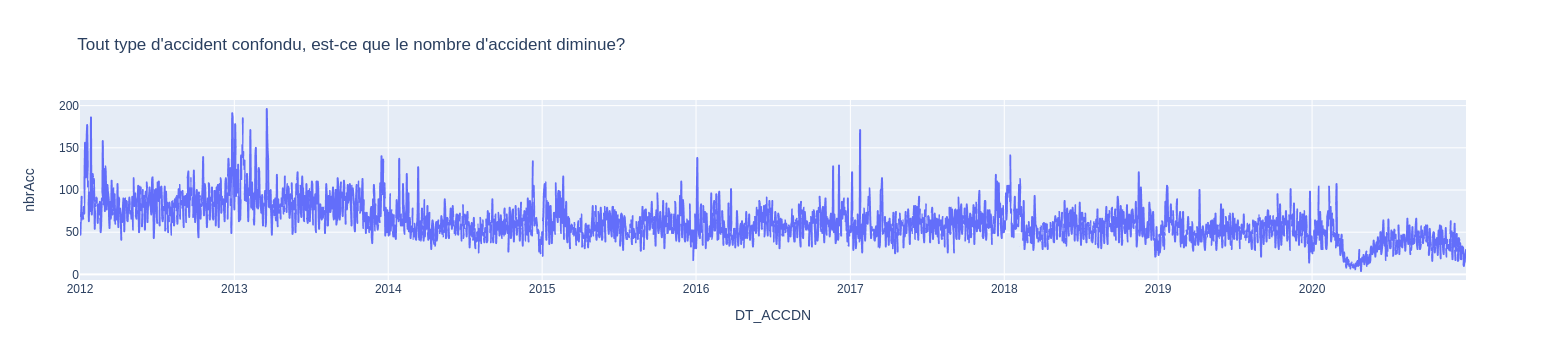

In [62]:
px.line(accAnnee.reset_index(), x='DT_ACCDN', y='nbrAcc', title="Tout type d'accident confondu, est-ce que le nombre d'accident diminue?")

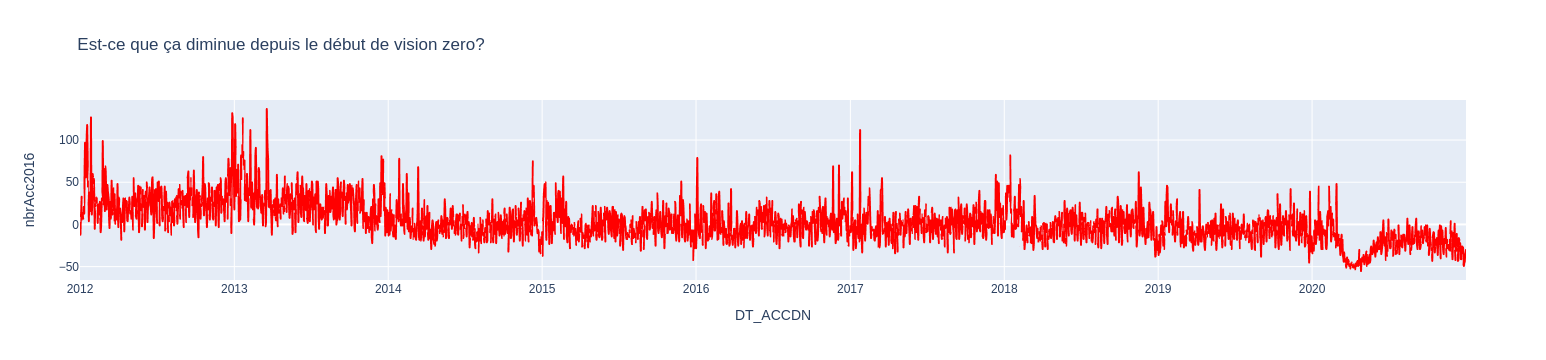

In [72]:
px.line(normAccAnnee.reset_index(), x='DT_ACCDN', y='nbrAcc2016', color_discrete_sequence=['red'], title="Est-ce que ça diminue depuis le début de vision zero?")

### Quand est-il pour les accidents graves ou mortels

In [102]:
graveMortelAnnee = graveMortel.groupby(['year', 'month']).count().iloc[:,0]
graveMortelAnnee.name = 'nrbGraveMortel'
meanGM20106 = graveMortel.groupby(['year', 'month', 'day']).count().loc[2016].mean().iloc[0]
normGraveMortelAnnee = graveMortelAnnee - meanGM20106
normGraveMortelAnnee.name = 'nbrAcc2016'

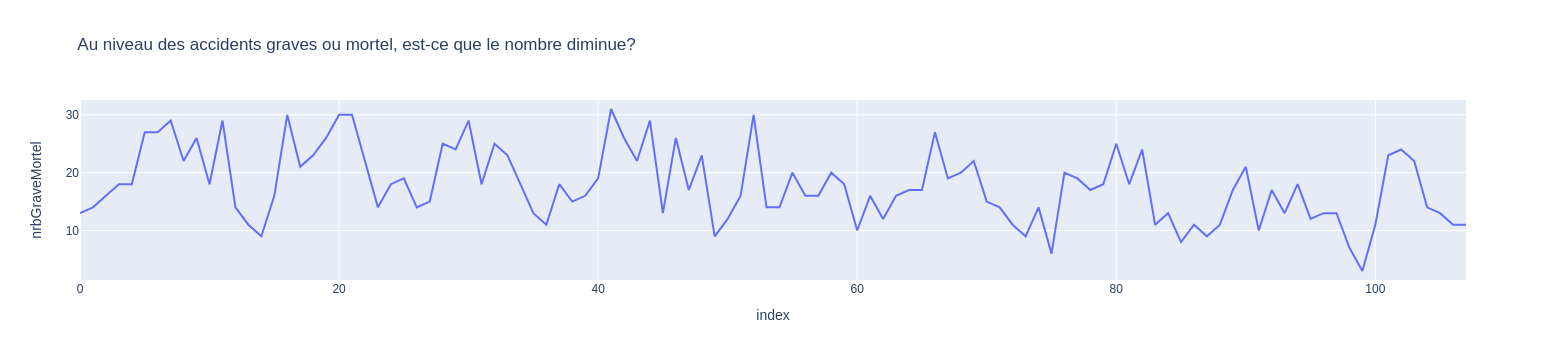

In [103]:
px.line(graveMortelAnnee.reset_index(), y='nrbGraveMortel', title="Au niveau des accidents graves ou mortel, est-ce que le nombre diminue?")


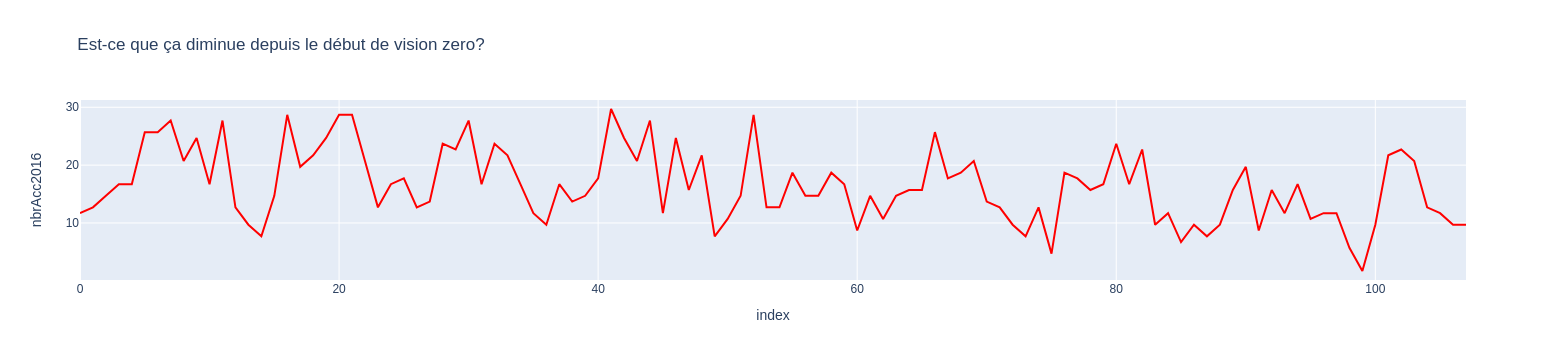

In [104]:
px.line(normGraveMortelAnnee.reset_index(), y='nbrAcc2016', color_discrete_sequence=['red'], title="Est-ce que ça diminue depuis le début de vision zero?")

# Par type de voiture tendence

In [114]:
dfTypeYear = df.groupby(['year', 'TYPE_IMPLIQUER']).count().iloc[:,0].reset_index(name='value')


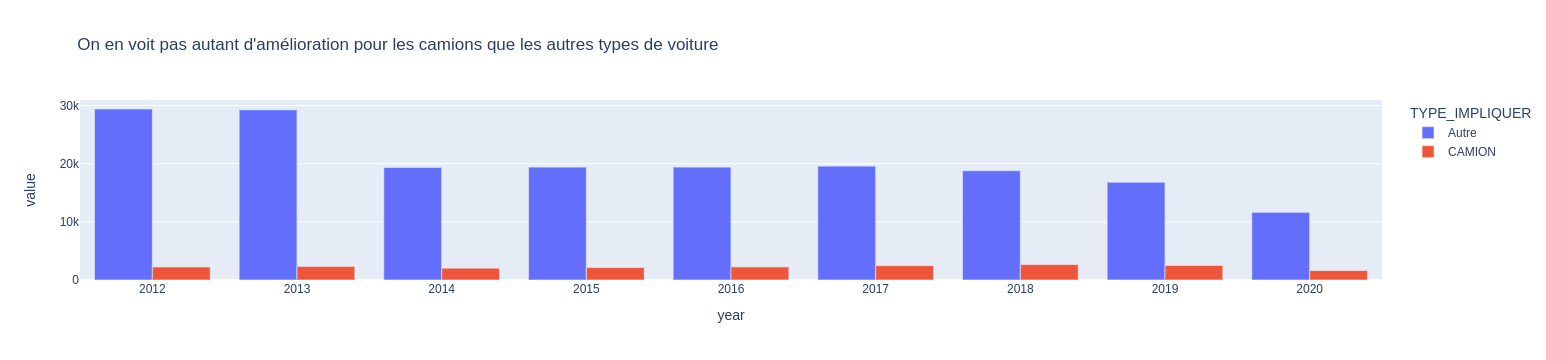

In [115]:
px.bar(dfTypeYear, x='year', y='value', color='TYPE_IMPLIQUER', barmode='group', title="On en voit pas autant d'amélioration pour les camions que les autres types de voiture")

In [116]:
dfTypeYearGravite = df.groupby(['GRAVITE', 'TYPE_IMPLIQUER', 'year']).count().iloc[:,0].reset_index(name='value')


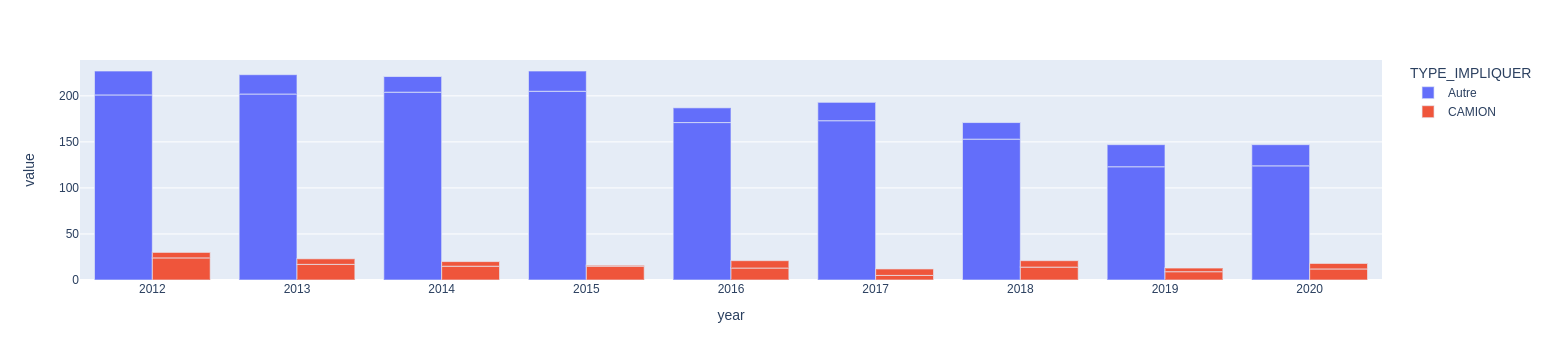

In [120]:
px.bar(dfTypeYearGravite[dfTypeYearGravite['GRAVITE'].isin(['Mortel', 'Grave'])], x='year', y='value', color='TYPE_IMPLIQUER', barmode='group', hover_data=)

# Section contexte d'accident camion

In [6]:
df.isna().sum().sort_values(ascending=False)[:20]

BORNE_KM_ACCDN        203951
CD_PNT_CDRNL_ROUTE    203794
SFX_NO_CIVIQ_ACCDN    203628
NO_ROUTE              203358
CD_ZON_TRAVX_ROUTR    199823
CD_SIT_PRTCE_ACCDN    199417
CD_POSI_ACCDN         158965
CD_ETAT_CHASS         155103
NB_METRE_DIST_ACCD    154413
CD_PNT_CDRNL_REPRR    139594
NO_CIVIQ_ACCDN        116758
VITESSE_AUTOR          80362
TP_REPRR_ACCDN         77383
ACCDN_PRES_DE          65969
CD_CONFG_ROUTE         20782
CD_LOCLN_ACCDN         16905
CD_COND_METEO          13065
CD_ECLRM               12407
CD_ETAT_SURFC          12306
RUE_ACCDN              12279
dtype: int64

In [33]:
dfType = df.drop(columns=['NO_SEQ_COLL', 'JR_SEMN_ACCDN', 'DT_ACCDN', 'CD_MUNCP',
       'NO_CIVIQ_ACCDN', 'SFX_NO_CIVIQ_ACCDN', 'BORNE_KM_ACCDN', 'RUE_ACCDN',
       'TP_REPRR_ACCDN', 'ACCDN_PRES_DE', 'NB_METRE_DIST_ACCD',
       'CD_SIT_PRTCE_ACCDN', 'NO_ROUTE', 'CD_POSI_ACCDN',
       'CD_ZON_TRAVX_ROUTR', 'CD_PNT_CDRNL_ROUTE', 'CD_PNT_CDRNL_REPRR',
       'NB_VEH_IMPLIQUES_ACCDN', 'HEURE_ACCDN', 'AN','REG_ADM', 'MRC', 'LOC_X',
       'LOC_Y', 'LOC_COTE_QD', 'LOC_COTE_PD', 'LOC_DETACHEE',
       'LOC_IMPRECISION', 'LOC_LONG', 'LOC_LAT', 'year', 'month', 'day',
       'weekday'])

dfType['CD_ETAT_CHASS'].fillna(1.0, inplace=True)
indexCat = ['CD_GENRE_ACCDN',
            'GRAVITE',
            'VITESSE_AUTOR',
            'CD_CATEG_ROUTE',
            'CD_ETAT_SURFC',
            'CD_ECLRM',
            'CD_ETAT_CHASS',
            'CD_ASPCT_ROUTE',
            'CD_LOCLN_ACCDN',
            'CD_CONFG_ROUTE',
            'CD_ENVRN_ACCDN',
            'CD_COND_METEO']

indexCat = ['CD_GENRE_ACCDN',
            'GRAVITE',
            'VITESSE_AUTOR',
            'CD_CATEG_ROUTE',
            'CD_ETAT_SURFC',
            'CD_ECLRM',
            'CD_ETAT_CHASS',
            'CD_ASPCT_ROUTE',
            'CD_LOCLN_ACCDN',
            'CD_CONFG_ROUTE',
            'CD_ENVRN_ACCDN',
            'CD_COND_METEO']

indexEnv =['GRAVITE', 'CD_ENVRN_ACCDN', 'CD_CATEG_ROUTE']

indexDes = ['GRAVITE',
            'VITESSE_AUTOR',
            'CD_CONFG_ROUTE',
            'CD_ASPCT_ROUTE']

indexExt = ['GRAVITE',
            'CD_COND_METEO',
            'CD_ETAT_SURFC',
            'CD_ETAT_CHASS',
            'CD_ECLRM']
            
            


In [21]:
df.columns

Index(['NO_SEQ_COLL', 'JR_SEMN_ACCDN', 'DT_ACCDN', 'CD_MUNCP',
       'NO_CIVIQ_ACCDN', 'SFX_NO_CIVIQ_ACCDN', 'BORNE_KM_ACCDN', 'RUE_ACCDN',
       'TP_REPRR_ACCDN', 'ACCDN_PRES_DE', 'NB_METRE_DIST_ACCD',
       'CD_GENRE_ACCDN', 'CD_SIT_PRTCE_ACCDN', 'CD_ETAT_SURFC', 'CD_ECLRM',
       'CD_ENVRN_ACCDN', 'NO_ROUTE', 'CD_CATEG_ROUTE', 'CD_ETAT_CHASS',
       'CD_ASPCT_ROUTE', 'CD_LOCLN_ACCDN', 'CD_POSI_ACCDN', 'CD_CONFG_ROUTE',
       'CD_ZON_TRAVX_ROUTR', 'CD_PNT_CDRNL_ROUTE', 'CD_PNT_CDRNL_REPRR',
       'CD_COND_METEO', 'NB_VEH_IMPLIQUES_ACCDN', 'NB_MORTS',
       'NB_BLESSES_GRAVES', 'NB_BLESSES_LEGERS', 'HEURE_ACCDN', 'AN',
       'NB_VICTIMES_TOTAL', 'GRAVITE', 'REG_ADM', 'MRC',
       'nb_automobile_camion_leger', 'nb_camionLourd_tractRoutier',
       'nb_outil_equipement', 'nb_tous_autobus_minibus', 'nb_bicyclette',
       'nb_cyclomoteur', 'nb_motocyclette', 'nb_taxi', 'nb_urgence',
       'nb_motoneige', 'nb_VHR', 'nb_autres_types', 'nb_veh_non_precise',
       'NB_DECES_PIETO

In [36]:
dfLourd = dfType[dfType['TYPE_IMPLIQUER'] == 'CAMION']
dfLourd.groupby(indexEnv).count()['NB_VICTIMES_TOTAL']

GRAVITE                                               CD_ENVRN_ACCDN  CD_CATEG_ROUTE
Dommages matériels inférieurs au seuil de rapportage  1.0             11.0               2
                                                                      12.0               2
                                                                      13.0              36
                                                                      14.0              67
                                                                      15.0               1
                                                                                        ..
Mortel                                                3.0             21.0               1
                                                      4.0             13.0               4
                                                                      21.0               1
                                                                      22.0               1
     

In [35]:
dfLourd = dfType[dfType['TYPE_IMPLIQUER'] == 'CAMION']
dfLourd.groupby(indexDes).count()['NB_VICTIMES_TOTAL'].loc['Mortel']

VITESSE_AUTOR  CD_CONFG_ROUTE  CD_ASPCT_ROUTE
10.0           9.0             11.0               1
30.0           1.0             13.0               1
               2.0             11.0               2
               4.0             11.0               1
40.0           1.0             11.0               1
                               13.0               1
               2.0             14.0               1
               3.0             11.0               2
50.0           1.0             11.0               4
               2.0             11.0               3
                               13.0               1
               3.0             11.0              13
                               12.0               1
               4.0             11.0               3
                               13.0               1
               5.0             11.0               2
Name: NB_VICTIMES_TOTAL, dtype: int64

In [16]:
catMelt = groupedCat.reset_index().melt(id_vars=indexCat)

In [24]:
groupedCat

NB_MORTS  \
CD_GENRE_ACCDN GRAVITE                                            VITESSE_AUTOR CD_CATEG_ROUTE CD_ETAT_SURFC CD_ECLRM CD_ETAT_CHASS CD_ASPCT_ROUTE CD_LOCLN_ACCDN CD_CONFG_ROUTE CD_ENVRN_ACCDN CD_COND_METEO             
31.0           Dommages matériels inférieurs au seuil de rappo... 10.0          11.0           11.0          3.0      1.0           14.0           32.0           1.0            9.0            11.0                  1   
                                                                                               16.0          1.0      1.0           11.0           32.0           5.0            4.0            17.0                  1   
                                                                                12.0           11.0          1.0      1.0           11.0           32.0           2.0            2.0            11.0                  1   
                                                                                13.0           11.0          1.0      1.0           11.0           31.0           3.0            4.0            11.0                  1   
                                                                                                                                                   32.0           3.0            3.0            11.0                  4   
...                                                                                                                                                                                                                 ...   
99.0           Léger                                              60.0          13.0           11.0          3.0      1.0           11.0           34.0           3.0            3.0            11.0                  1   
                                                                                                                                    13.0           32.0           5.0            4.0            11.0                  1   
                                                                                                                      5.0           11.0           33.0           3.0            4.0            11.0                  1   
                                                                                               16.0          1.0      1.0           11.0           34.0           3.0            4.0            11.0                  1   
                                                                  80.0          13.0           11.0          1.0      5.0           11.0           32.0           3.0            3.0            11.0                  1   

                                                                                                                                                                                                               NB_BLESSES_GRAVES  \
CD_GENRE_ACCDN GRAVITE                                            VITESSE_AUTOR CD_CATEG_ROUTE CD_ETAT_SURFC CD_ECLRM CD_ETAT_CHASS CD_ASPCT_ROUTE CD_LOCLN_ACCDN CD_CONFG_ROUTE CD_ENVRN_ACCDN CD_COND_METEO                      
31.0           Dommages matériels inférieurs au seuil de rappo... 10.0          11.0           11.0          3.0      1.0           14.0           32.0           1.0            9.0            11.0                           1   
                                                                                               16.0          1.0      1.0           11.0           32.0           5.0            4.0            17.0                           1   
                                                                                12.0           11.0          1.0      1.0           11.0           32.0           2.0            2.0            11.0                           1   
                                                                                13.0           11.0          1.0      1.0           11.0           31.0           3.0            4.0            11.0                       

In [17]:
catMelt.sort_values('value', ascending=False)

,CD_GENRE_ACCDN,GRAVITE,VITESSE_AUTOR,CD_CATEG_ROUTE,CD_ETAT_SURFC,CD_ECLRM,CD_ETAT_CHASS,CD_ASPCT_ROUTE,CD_LOCLN_ACCDN,CD_CONFG_ROUTE,CD_ENVRN_ACCDN,CD_COND_METEO,variable,value
873151,31.0,Dommages matériels seulement,50.0,13.0,11.0,1.0,1.0,11.0,32.0,3.0,3.0,11.0,NB_BLESSES_VELO,1489
1016751,31.0,Dommages matériels seulement,50.0,13.0,11.0,1.0,1.0,11.0,32.0,3.0,3.0,11.0,NB_BLESSE_VELO_PIETON,1489
1052651,31.0,Dommages matériels seulement,50.0,13.0,11.0,1.0,1.0,11.0,32.0,3.0,3.0,11.0,TYPE_IMPLIQUER,1489
944951,31.0,Dommages matériels seulement,50.0,13.0,11.0,1.0,1.0,11.0,32.0,3.0,3.0,11.0,GRAVE_MORT,1489
980851,31.0,Dommages matériels seulement,50.0,13.0,11.0,1.0,1.0,11.0,32.0,3.0,3.0,11.0,NB_BLESSE_VEHICULE,1489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412292,31.0,Léger,40.0,14.0,11.0,1.0,1.0,21.0,34.0,1.0,2.0,11.0,nb_taxi,1
412294,31.0,Léger,40.0,14.0,11.0,1.0,1.0,21.0,99.0,2.0,2.0,12.0,nb_taxi,1
412295,31.0,Léger,40.0,14.0,11.0,1.0,2.0,11.0,32.0,1.0,2.0,12.0,nb_taxi,1
412296,31.0,Léger,40.0,14.0,11.0,1.0,2.0,11.0,32.0,2.0,2.0,11.0,nb_taxi,1


In [22]:
camionResDf = df.groupby(['CD_GENRE_ACCDN', 'CD_CATEG_ROUTE', 'year', 'HEURE_ACCDN', 'GRAVITE']).sum().loc[(31.0,14.0)]['NB_VIC'].reset_index().melt(id_vars=['HEURE_ACCDN', 'year', 'GRAVITE'])

KeyError: 'NB_VIC'

In [ ]:
camionResDf

In [8]:
px.bar(camionResDf, x='HEURE_ACCDN', y='value', color='GRAVITE', facet_row='year', height=800)

NameError: name 'camionResDf' is not defined